- Create a good validation schema
- Implement evaluation metric

### Example Metric Implementation

In [77]:
%matplotlib inline
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import skimage.segmentation

# Load a single image and its associated masks
id = '0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9'
file = "../data/ds_bowl_2018/train/{}/images/{}.png".format(id,id)
masks = "../data/ds_bowl_2018/train/{}/masks/*.png".format(id)
image = skimage.io.imread(file)
masks = skimage.io.imread_collection(masks).concatenate()
height, width, _ = image.shape
num_masks = masks.shape[0]

# Make a ground truth label image (pixel value is index of object label)
labels = np.zeros((height, width), np.uint16)
for index in range(0, num_masks):
    labels[masks[index] > 0] = index + 1

Text(0.5,1,'Ground truth masks')

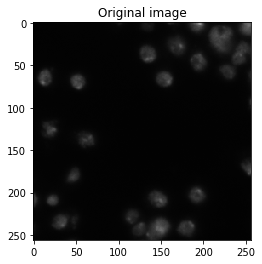

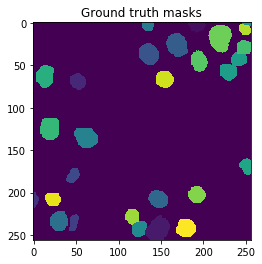

In [78]:
# Show label image
fig = plt.figure()
plt.imshow(image)
plt.title("Original image")
fig = plt.figure()
plt.imshow(labels)
plt.title("Ground truth masks")

In [85]:
# Simulate an imperfect submission
offset = 2 # offset pixels
y_pred = labels[offset:, offset:]
y_pred = np.pad(y_pred, ((0, offset), (0, offset)), mode="constant")
y_pred[y_pred == 20] = 0 # Remove one object
y_pred, _, _ = skimage.segmentation.relabel_sequential(y_pred) # Relabel objects

Text(0.5,1,'Simulated imperfect submission')

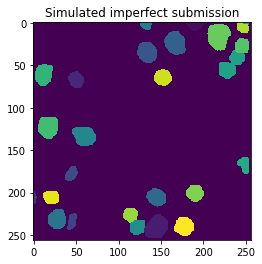

In [86]:
# Show simulated predictions with shifted segmentations
# and 1 missing mask
fig = plt.figure()
plt.imshow(y_pred)
plt.title("Simulated imperfect submission")

In [90]:
# Compute number of objects
true_objects = len(np.unique(labels))-1
pred_objects = len(np.unique(y_pred))-1
print("Number of true objects:", true_objects)
print("Number of predicted objects:", pred_objects)

Number of true objects: 27
Number of predicted objects: 26


In [103]:
intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), 
              bins=(true_objects, pred_objects))[0]

In [104]:
# Compute areas (needed for finding the union between all objects)
area_true = np.histogram(labels, bins = true_objects)[0]
area_pred = np.histogram(y_pred, bins = pred_objects)[0]
area_true = np.expand_dims(area_true, -1)
area_pred = np.expand_dims(area_pred, 0)

In [110]:
area_true.shape, area_pred.shape

((27, 1), (1, 26))

In [106]:
# Compute union
union = area_true + area_pred - intersection

In [114]:
union[union==0] = 1e-9

In [117]:
iou = intersection / union

In [119]:
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1   # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    return tp, fp, fn

In [124]:
# Loop over IoU thresholds
prec = []
print("Thresh\tTP\tFP\tFN\tPrec.")
for t in np.arange(0.5, 1.0, 0.05):
    tp, fp, fn = precision_at(t, iou)
    p = tp / (tp + fp + fn)
    print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
    prec.append(p)
print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

Thresh	TP	FP	FN	Prec.
0.500	25	1	2	0.893
0.550	24	2	3	0.828
0.600	22	4	5	0.710
0.650	18	8	9	0.514
0.700	13	13	14	0.325
0.750	5	21	22	0.104
0.800	1	25	26	0.019
0.850	1	25	26	0.019
0.900	1	25	26	0.019
0.950	0	26	27	0.000
AP	-	-	-	0.343
